## DDM

In [179]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm

In [ ]:
from

## Model parameters

lb → 0, 
ub → a (0.5, 2),
z → (0,1)
drift-gain → (0, some number)
drift-offset → (-some number*100, + some number*100)
leak → (0,xx)
dt → 1ms
Ter → (0, maxRT)
time-varying weights → exp(- lambda* t) 
lambda→(0,1)

In [148]:
def get_psychometric_data(data, positive_direction="right"):
    """Extracts psychometric data and optionally fits a model."""
    unique_coh = np.unique(data["signed_coherence"])
    x_data = np.where(positive_direction == "left", -unique_coh, unique_coh)
    y_data = []
    trial_counts = []
    for coh in unique_coh:
        mask = (data["signed_coherence"] == coh) & (~np.isnan(data["choice"]))
        total_trials = np.sum(mask)

        if total_trials == 0:
            continue  # Skip coherence levels with no trials

        prop_positive = np.mean(data["choice"][mask] == (positive_direction == "right"))
        y_data.append(prop_positive)
        trial_counts.append(total_trials)

    # Convert to numpy arrays and sort
    x_data, y_data, trial_counts = map(np.array, zip(*sorted(zip(x_data, y_data, trial_counts, strict=False)), strict=False))


    return x_data, y_data


def get_chronometric_data(data, positive_direction="right"):
    """Computes reaction time statistics for different coherence levels."""
    unique_coh = np.unique(data["signed_coherence"])
    coherences, rt_median, rt_mean, rt_sd, rt_sem = [], [], [], [], []

    for coh in unique_coh:
        trials = data[data["signed_coherence"] == coh]
        if trials.empty:
            continue

        coherences.append(coh if positive_direction == "right" else -coh)
        rt_median.append(np.median(trials["response_time"]))
        rt_mean.append(np.mean(trials["response_time"]))
        rt_sd.append(np.std(trials["response_time"]))
        rt_sem.append(stats.sem(trials["response_time"],nan_policy='omit'))

    return map(np.array, zip(*sorted(zip(coherences, rt_median, rt_mean, rt_sd, rt_sem, strict=False)), strict=False))


In [ ]:
# stimulus_length = np.random.randint(300,1000,size=1000)
stimulus = np.full((1000, 1000), np.nan)
coherence_levels = [-0.5, -0.2, -0.06, 0.0, 0.06, 0.2, 0.5]
for i in range(1000):
    stimulus[i, :] = np.random.choice(coherence_levels)


In [ ]:
class DiffusionModel:
    def __init__(self):
        """Initialize parameters for the diffusion model."""
        self.ndt = 0.1      # non-decision time
        self.a = 2        # boundary separation
        self.z = 0.5          # starting point (as a proportion of a)
        self.drift_gain = 7 # gain on the input to get drift rate
        self.drift_offset = 0.0
        self.variance = 1   # variance of the noise in the accumulation process
        self.dt = 0.001        # time step for simulation
        self.leak_rate = 0.01     # leakage parameter
        self.time_constant = 0#1e-2 # urgency signal time constant

    def simulate_trials(self, stimulus):
        """Simulate trials of the diffusion model given a stimulus."""
        n_trials = stimulus.shape[0]
        n_timepoints = stimulus.shape[1]

        # Preallocate arrays for decision variables and responses
        dv = np.full((n_trials, n_timepoints),np.nan)
        rt = np.full(n_trials, np.nan)
        choice = np.full(n_trials, np.nan)

        # Calculate drift rates based on stimulus and gain
        drift_rates = self.drift_gain * stimulus + self.drift_offset
        starting_point = self.z * self.a
        for trial in range(n_trials):
            dv[trial, 0] = starting_point
            for t in range(1, n_timepoints):
                if np.isnan(stimulus[trial, t]):
                    break # no response
                noise = np.random.normal(0, np.sqrt(self.variance * self.dt))
                dv[trial, t] = dv[trial, t-1] + (drift_rates[trial, t-1] * self.dt) + noise + (-self.leak_rate * (dv[trial, t-1]- starting_point) * self.dt)

                # Check for boundary crossing
                if dv[trial, t] >= self.a:
                    rt[trial] = t * self.dt + self.ndt
                    choice[trial] = 1
                    dv[trial, t:] = self.a  # Hold DV at boundary after crossing
                    break
                elif dv[trial, t] <= 0:
                    rt[trial] = t * self.dt + self.ndt
                    choice[trial] = 0
                    dv[trial, t:] = 0  # Hold DV at boundary after crossing
                    break
        return rt, choice, dv

    def fit(self, stimulus, choices, rts, n_sim=500):
        """
        Fit the diffusion model parameters to choice and RT data given stimulus.

        Parameters:
            stimulus: (n_trials, n_timepoints) array of stimulus
            choices: (n_trials,) array of observed choices (0 or 1)
            rts: (n_trials,) array of observed reaction times
            n_sim: number of simulated trials per loss eval

        Returns:
            result: OptimizeResult with fitted params in result.x
        """

        # Define loss function: negative log likelihood of observed data given model params
        def neg_log_likelihood(params):
            a, drift_gain, variance, ndt = params
            # Enforce sensible bounds internally to avoid invalid params
            if a <= 0 or variance <= 0 or ndt < 0:
                return np.inf
            self.a = a
            self.drift_gain = drift_gain
            self.variance = variance
            self.ndt = ndt

            # Simulate trials
            sim_rt, sim_choice, _ = self.simulate_trials(stimulus[:n_sim])
            # Remove NaNs
            mask = ~np.isnan(sim_rt) & ~np.isnan(sim_choice)
            sim_rt = sim_rt[mask]
            sim_choice = sim_choice[mask]

            # Compute likelihood of observed choices under simulated choice probabilities
            # Use kernel density or approximate by binning RT & choice distributions

            # Approximate: compare empirical prob of choice given stimulus with model choice frequency
            model_choice_prob = np.mean(sim_choice == 1)
            data_choice_prob = np.mean(choices == 1)

            # Likelihood from choices: Bernoulli log likelihood for each observed choice
            eps = 1e-9  # avoid log(0)
            choice_ll = np.sum(choices * np.log(model_choice_prob + eps) + (1-choices)*np.log(1-model_choice_prob + eps))

            # For RT, compute likelihood assuming Gaussian around simulated RT mean for correct choices
            # (this is a simplification; ideally use full RT distribution)
            if np.sum(sim_choice == 1) == 0:
                return np.inf  # avoid division by zero
            mean_rt_1 = np.mean(sim_rt[sim_choice == 1])
            std_rt_1 = np.std(sim_rt[sim_choice == 1]) + 1e-3  # avoid zero std

            mean_rt_0 = np.mean(sim_rt[sim_choice == 0])
            std_rt_0 = np.std(sim_rt[sim_choice == 0]) + 1e-3

            # Calculate RT likelihoods
            rt_ll_1 = np.sum(norm.logpdf(rts[choices == 1], mean_rt_1, std_rt_1))
            rt_ll_0 = np.sum(norm.logpdf(rts[choices == 0], mean_rt_0, std_rt_0))

            total_ll = choice_ll + rt_ll_1 + rt_ll_0
            return -total_ll

        # Initial guess and bounds for parameters
        x0 = [self.a, self.drift_gain, self.variance, self.ndt]
        bounds = [(0.1, 5.0),    # a
                  (0.1, 20.0),   # drift_gain
                  (0.01, 5.0),   # variance
                  (0.0, 0.5)]    # ndt

        result = minimize(neg_log_likelihood, x0, bounds=bounds, method='L-BFGS-B')

        # Update model params with best fit
        if result.success:
            self.a, self.drift_gain, self.variance, self.ndt = result.x
        else:
            print("Fit failed:", result.message)

        return result


In [142]:
choice[stimulus[:,0]==0]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

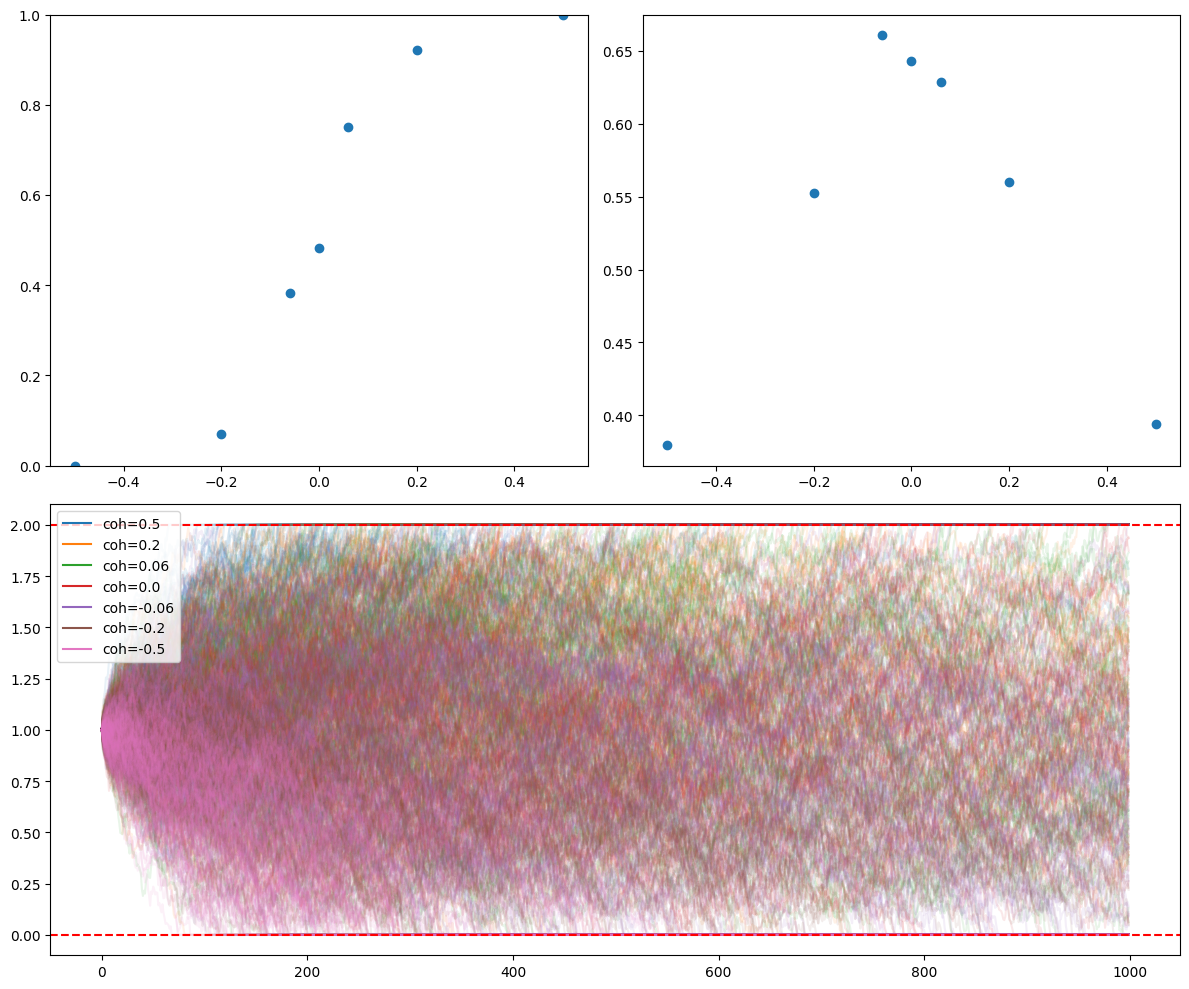

Proportion of invalid trials: 0.222


In [178]:
ddm = DiffusionModel()

ddm.ndt = 0.1      # non-decision time
ddm.a = 2        # boundary separation
ddm.z = 0.5          # starting point (as a proportion of a)
ddm.drift_gain = 7 # gain on the input to get drift rate
ddm.drift_offset = 0.0
ddm.variance = 1   # variance of the noise in the accumulation process
ddm.dt = 0.001        # time step for simulation
ddm.leak_rate = 0     # leakage parameter
ddm.time_constant = 0#1e-2 # urgency signal time constant



rt, choice,dv = ddm.simulate_trials(stimulus)
data = pd.DataFrame({
    "signed_coherence": stimulus[:,0].flatten(),
    "choice": choice.flatten(),
    "response_time": rt.flatten(),
})
x_data, y_data = get_psychometric_data(data)
_,_,rt_mean,_,_ = get_chronometric_data(data)
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(2, 2)

# Top-left subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x_data, y_data, 'o')
ax1.set_ylim(0, 1)

# Top-right subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x_data, rt_mean, 'o')


# Bottom subplot spanning both columns
ax3 = fig.add_subplot(gs[1, :])
for coh in coherence_levels:
    ax3.plot(dv[stimulus[:,0]==coh].T, color=sns.color_palette("tab10")[coherence_levels.index(coh)], alpha=0.1)
    ax3.plot([],[], color=sns.color_palette("tab10")[coherence_levels.index(coh)], alpha=1, label=f'coh={coh}')
ax3.axhline(ddm.a, color='red', linestyle='--')
ax3.axhline(0, color='red', linestyle='--')
ax3.legend()

plt.tight_layout()
plt.show()

print("Proportion of invalid trials:", np.mean(np.isnan(choice)))

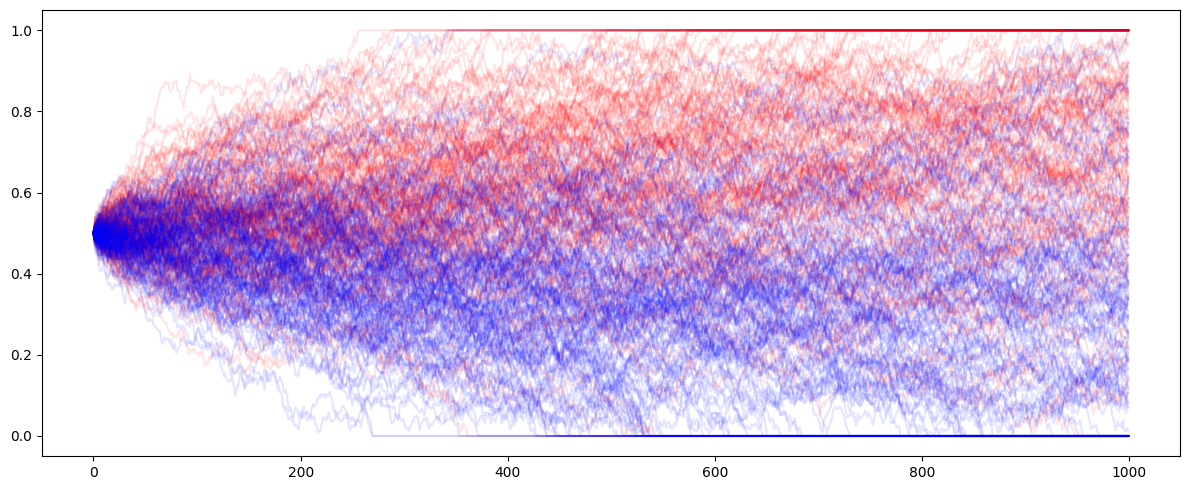

Proportion of invalid trials: 0.292


In [128]:

fig = plt.figure(figsize=(12,5))
gs = gridspec.GridSpec(2, 2)

coh_to_plot = 0.06
plt.plot(dv[(stimulus[:,0])==coh_to_plot].T, color='r', alpha=0.1)
plt.plot(dv[(stimulus[:,0])==-coh_to_plot].T, color='b', alpha=0.1)
plt.plot([],[], color='r', alpha=1, label=f'coh={coh}')
plt.plot([],[], color='b', alpha=1, label=f'coh={-coh}')


plt.tight_layout()
plt.show()

print("Proportion of invalid trials:", np.mean(np.isnan(choice)))